# Interpret the results obtained from each of the experiments

The results from the experiments involve interpreting and plotting several quantities
- CPU Utilization of the slaves during the experiments
- IO Wait of the slaves during the experiments
- Accuracy of the final model after 10 epochs
- Response time of the model after 10 epochs

(Possible other result to see)
- Throughput of the model

In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
from collections import defaultdict
import glob
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# For the ANOVA test
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols


## Extract from the log files the Accuracy and the Response Time

The files are in the folder from the master server, and we get a final line in the files with
the total wall clock time and the final accuracy

The folder structure taken into consideration is the following, from the root folder for the set
of experiments in question (2k or full) we get 4 folders, 1 for the master and 1 for each slave,
and inside these folders we get 1 folder for each of the replications. Inside we should find the
pickle files and the log files in case of the master


In [84]:

def split_name(exp_name: str) -> (int, int, int):
    """Given the name of the file give back the settings of the experiment"""
    parts = exp_name.split('-')
    cpu = int(parts[0].replace('cpu', '').strip())
    batch = int(parts[1].replace('batch', '').strip())
    njobs = int(parts[2].replace('njobs', '').strip())
    network = str(parts[3])[3:] if len(parts) > 3 else 'lenet'

    return cpu, batch, njobs, network

# Read the folder os the master and search for the accuracy to build the dictionary
# Right now for testing it just has one replication



# Get a dict ready to transform into a dataframe for training of the
# model and representation
results = {
    'exp_name': [],
    'replication': [],
    'cpu': [],
    'batch': [],
    'njobs': [],
    'network': [],
    'time': [],
    'accuracies':[],
    'final_accuracy': []
}
# Just take the final valuie for the ANOVA test
# res_final = defaultdict(dict)


replications = 3

for r in range(1, 1+replications):
    # This is the path we should change to either analyze the 2k or the full factorial
    path_root_master = f'./experiments/fullfact/{r}/master/'
    
    # get the log files
    logs = glob.glob(os.path.join(path_root_master, '*.log'))
    
    
    print(f'Extracting the data from {len(logs)} files')
    for log in logs:
        acc = []
        with open(log, 'r') as f:
            for line in f:
                if 'Top1Accuracy is Accuracy' in line:
                    try:
                        _accuracy = line.strip().split(']')[-1].split(',')[-1].split(':')[-1].replace(')', '')
                        acc.append(float(_accuracy.strip()))
                    except Exception as e:
                        print('Error while reading accuracy',e)
                    if len(acc) == 10:
                        # Then save the time here
                        time = float(line.strip().split(']')[-2].split('[')[-1].split(' ')[-1].replace('s', ''))
                        break
        # Add the results to the dictionary
        variables = log.split('-')[1:]
        if len(variables) < 4:
            variables[-1] = variables[-1].split('.')[0]
            variables.append('netlenet5')
        name = '-'.join(variables).replace('.log', '')
        cpu, batch, njobs , network= split_name(name)
        # set all the columns
        results['cpu'].append(cpu)
        results['batch'].append(batch)
        results['njobs'].append(njobs)
        results['network'].append(network)
        results['accuracies'].append(acc)
        results['time'].append(time)
        results['final_accuracy'].append(acc[-1])
        results['exp_name'].append(name)
        results['replication'].append(r)


results_df = pd.DataFrame(results)
# results_df = results_df.set_index('exp_name')

# We should get the last accuracy to run ANOVA but to plot this is better
results_df


Extracting the data from 96 files
Error while reading accuracy could not convert string to float: 'validate model throughput is 23402.63 records/second'
Error while reading accuracy could not convert string to float: 'Save model to /tmp/simplenet/20201021_135727'
Extracting the data from 96 files
Error while reading accuracy could not convert string to float: 'validate model throughput is 22114.438 records/second'
Error while reading accuracy could not convert string to float: 'Save model to /tmp/lenet5/20201021_182017'
Error while reading accuracy could not convert string to float: 'Save model to /tmp/lenet5/20201021_182354'
Error while reading accuracy could not convert string to float: 'Current learning rate is 0.008931761343336907. Current dampening is 1.7976931348623157E308.'
Error while reading accuracy could not convert string to float: 'Current learning rate is 0.008406186953597848. Current dampening is 1.7976931348623157E308.'
Extracting the data from 96 files
Error while read

,exp_name,replication,cpu,batch,njobs,network,time,accuracies,final_accuracy
0,cpu1-batch64-njobs1-netlenet5,1,1,64,1,lenet5,493.510662,"[0.8841, 0.9189, 0.9298, 0.9374, 0.9421, 0.946...",0.9567
1,cpu2-batch64-njobs1-netlenet5,1,2,64,1,lenet5,477.422871,"[0.8794, 0.9127, 0.927, 0.9359, 0.9412, 0.9469...",0.9580
2,cpu4-batch256-njobs1-netlenet5,1,4,256,1,lenet5,153.519246,"[0.6808, 0.8058, 0.8565, 0.8815, 0.8948, 0.906...",0.9288
3,cpu8-batch256-njobs1-netlenet5,1,8,256,1,lenet5,153.905961,"[0.6872, 0.7999, 0.8486, 0.8739, 0.8889, 0.9, ...",0.9213
4,cpu1-batch512-njobs1-netlenet5,1,1,512,1,lenet5,179.730715,"[0.5992, 0.7516, 0.7949, 0.8287, 0.8485, 0.864...",0.8957
...,...,...,...,...,...,...,...,...,...
283,cpu8-batch256-njobs5-netsimplenet,3,8,256,5,simplenet,286.563515,"[0.8718, 0.8915, 0.9006, 0.9062, 0.9124, 0.915...",0.9268
284,cpu1-batch512-njobs5-netsimplenet,3,1,512,5,simplenet,115.670287,"[0.8274, 0.8676, 0.886, 0.896, 0.9012, 0.9048,...",0.9144
285,cpu2-batch512-njobs5-netsimplenet,3,2,512,5,simplenet,129.902991,"[0.8235, 0.8682, 0.8876, 0.8952, 0.9004, 0.904...",0.9132
286,cpu4-batch512-njobs5-netsimplenet,3,4,512,5,simplenet,129.902991,"[0.871, 0.8855, 0.8936, 0.8998, 0.9031, 0.9061...",0.9119


# Extract the CPU and IO wait from the pickle files

In this case we need the slave folders (we will check that the folder contains the word slave to analyze the files)
and we will extract the pickle files from where we will get the CPU load and the IO wait percentage

There is a thing to take in mind. The experiment runs for a default of 5 minutes, so if the experiment lasted
less than 300 seconds, which we can get from the results dictionary from before, we should trim the vectors taking
into account that each measurement is taken every 2 seconds so it just comprises that experiment and doesn't
introduce noise from the next

In [87]:
def coalesce_metrics(loads, replication, threshold = 1):
    """We have three slaves, and sometimes not all of them are working
    if the numnber of cpus and jobs is just one

    In these cases,  discard the lists with an average too close to zero,
    if not, add the slaves together and calculate the mean at each point to
    get the final vector."

    :param: threshold: the threshold of utilization under which we conside
                        that the server was not used in the experiment"""
    # Dict to build the dataframe
    avg_loads = {
        'exp_name': [],
        'replication': [],
        'cpu_load': [],
        'iowait': [],
        'cpu_mean': [],
        'iowait_mean':[]
    }

    for exp, slaves in loads.items():
        # print(f'\n{exp}')
        count = 0
        list_length = len(list(slaves['slave1'].values())[0])
        c = np.zeros(list_length)
        io = np.zeros(list_length)
        for slave, metrics in slaves.items():

            # if the mean is too slow discard
            cpu_mean = np.mean(metrics['cpu'])
            if  cpu_mean <threshold:
                # print(f'Discarding {slave} with cpu mean =',cpu_mean)
                pass
            else:
                c += metrics['cpu']
                io += metrics['iowait']
                count += 1
                # print(slave, np.mean(metrics['cpu']), np.mean(metrics['iowait']))
                # print(metrics['cpu'])

        # print('dividing by ',count)
        avg_loads['exp_name'].append(exp)
        avg_loads['replication'].append(replication)
        avg_loads['cpu_load'].append(c / count)
        avg_loads['iowait'].append(io/count)
        avg_loads['cpu_mean'].append(np.mean(c/count))
        avg_loads['iowait_mean'].append(np.mean(io/count))


        # avg_loads[exp] = {
        #     'cpu': c / count,
        #     'iowait': io/count,
        #     'cpu_mean': np.mean(c/count),
        #     'iowait_mean':np.mean(io/count)
        # }

    return avg_loads

In [88]:
dfs = []

for replication in [1, 2, 3]:
    print('Starting with replication ',replication)
    root_folder_slaves = f'./experiments/fullfact/{replication}'

    dirs = os.listdir(root_folder_slaves)
    slave_dirs = [f for f in dirs if 'slave' in f]
    print(slave_dirs)


    loads = defaultdict(dict)
    # The shape of the results is
    # name of the file:
    #     - slave 1:
    #         - cpu: list
    #         - iowait: list
    #     - slave 2:
    #         ...

    # Do the same in all the folders
    for folder in slave_dirs:
        print('Processing files for the', folder)
        # get just the pickle files
        files = glob.glob(os.path.join(root_folder_slaves, folder, '*.pkl'))

        # Extract the dictionary from each file
        for f in files:

            # Get the name of the experiment to index the other dict
            variables = f.split('-')[1:]
            if len(variables) < 4:
                variables.append('netlenet5')
            exp_name = '-'.join(variables).replace('.pkl', '')
#             print(exp_name)
#             print(f)

            with open(f, 'rb') as pickle_file:
                metrics = pickle.load(pickle_file)

            # Now we need to check to just get the metrics concerning the experiment
            # And not the following. We leave a margin of 10 seconds or 5 list positions just in case
            # to not cut too tightly
            exp_length = results_df.loc[(results_df.exp_name == exp_name) & (results_df.replication == replication), 'time'].array[0]
            if exp_length > 300:
                loads[exp_name][folder] = metrics

            else:
                max_list_length = math.ceil(exp_length/2) + 5
                # print(f'Exp length was {exp_length}, so max list positions are {max_list_length}')
                if max_list_length < len(metrics['cpu']):
                    loads[exp_name][folder] = dict()
                    loads[exp_name][folder]['cpu'] = metrics['cpu'][:max_list_length]
                    loads[exp_name][folder]['iowait'] = metrics['iowait'][:max_list_length]
                else:
                    # Add the whole of it
                    loads[exp_name][folder] = metrics

    # Get the average usage of the experiments
    # The resulting dict will just map each
    # pf the experiments to its avg cpu load and
    # iowait across all slaves

    avg_loads = coalesce_metrics(loads, replication)
    loads_df = pd.DataFrame(avg_loads)
    print('build dataframe')
    dfs.append(loads_df)

# Concat all of the dataframes into one
load_df = None

for df in dfs:
    load_df = df if results_df is None else pd.concat([load_df, df], ignore_index=True)

Starting with replication  1
['slave1', 'slave2', 'slave3']
Processing files for the slave1
Processing files for the slave2
Processing files for the slave3
build dataframe
Starting with replication  2
['slave1', 'slave2', 'slave3']
Processing files for the slave1
Processing files for the slave2
Processing files for the slave3
build dataframe
Starting with replication  3
['slave1', 'slave2', 'slave3']
Processing files for the slave1
Processing files for the slave2
Processing files for the slave3
build dataframe


3

### Merge the dataframes together so we get a common dataframe for all results


In [98]:
# Merge the two dataframes so we get all the data grouped by experiment number
final_df = results_df.merge(load_df, on=['exp_name', 'replication'])

3    96
2    96
1    96
Name: replication, dtype: int64

# If everything is already done load the data from the file

In [ ]:
final_df = pd.read_pickle('./experiments/complete_data.pkl')

## Plot the loads for each of the slaves for each of the experiments

In some experiments some of the slaves have zero load cause they are not used, in those cases
we should filter out the lists whose average is too close to zero. In other cases, we can just average the
load among all of the slaves.

### See the relationship with time

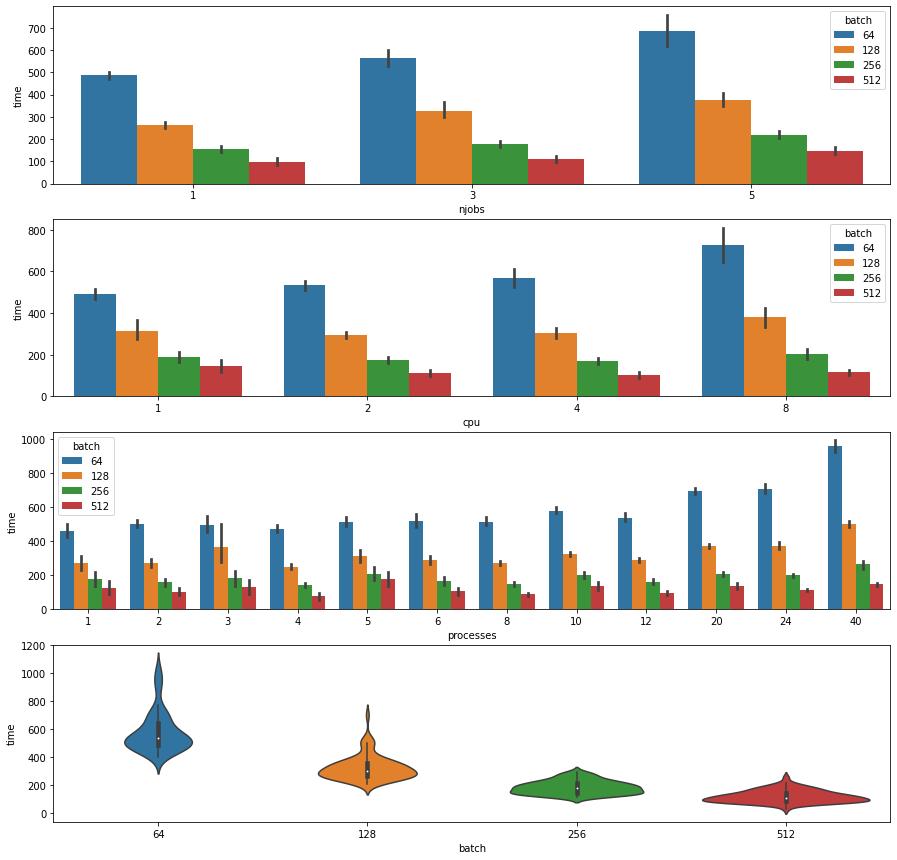

In [108]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.barplot(x='njobs', y='time', hue='batch', data=final_df, ax=ax1)
sns.barplot(x='cpu', y='time', hue='batch', data=final_df, ax=ax2)

final_df['processes'] = final_df['cpu'] * final_df['njobs']
sns.barplot(x='processes', y='time', hue='batch',data=final_df, ax=ax3)
sns.violinplot(x='batch', y='time', data=final_df, ax=ax4);


### See the relationships with the accuracy


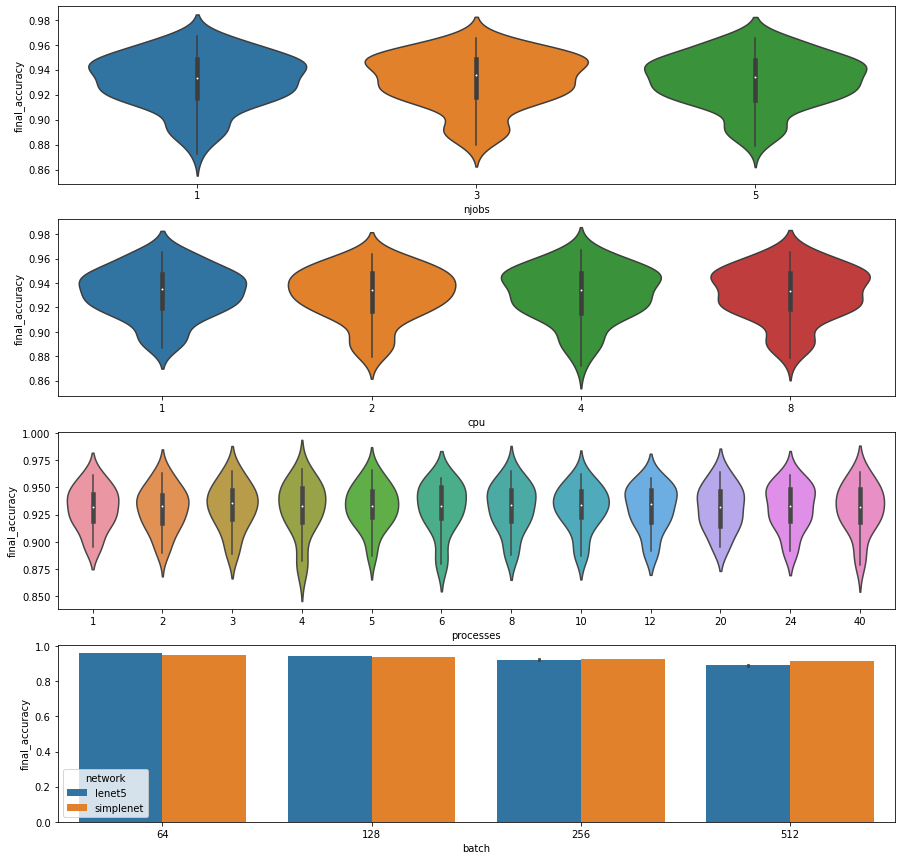

In [109]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.violinplot(x='njobs', y='final_accuracy', data=final_df, ax=ax1)
sns.violinplot(x='cpu', y='final_accuracy', data=final_df, ax=ax2)

final_df['processes'] = final_df['cpu'] * final_df['njobs']
sns.violinplot(x='processes', y='final_accuracy', data=final_df, ax=ax3)
sns.barplot(x='batch', y='final_accuracy', hue='network', data=final_df, ax=ax4);


### See the relationship with the cpu load and iowait

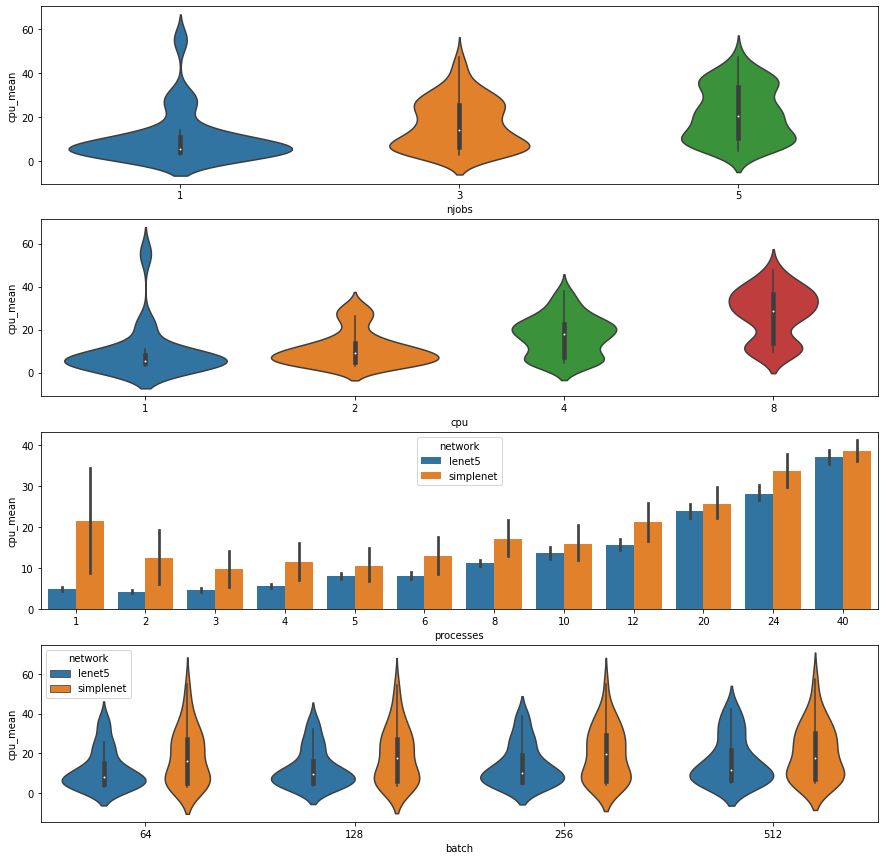

In [110]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.violinplot(x='njobs', y='cpu_mean', data=final_df, ax=ax1)
sns.violinplot(x='cpu', y='cpu_mean', data=final_df, ax=ax2)

final_df['processes'] = final_df['cpu'] * final_df['njobs']
sns.barplot(x='processes', y='cpu_mean', hue='network', data=final_df, ax=ax3)
sns.violinplot(x='batch', y='cpu_mean', hue = 'network', data=final_df, ax=ax4);




,replication,cpu,batch,time,final_accuracy,cpu_mean,iowait_mean,processes
njobs,,,,,,,,
1,2.0,3.75,240.0,251.127388,0.930870,11.023221,0.136740,3.75
3,2.0,3.75,240.0,295.221406,0.931409,16.763207,0.813145,11.25
5,2.0,3.75,240.0,357.943036,0.931164,21.675029,2.138145,18.75


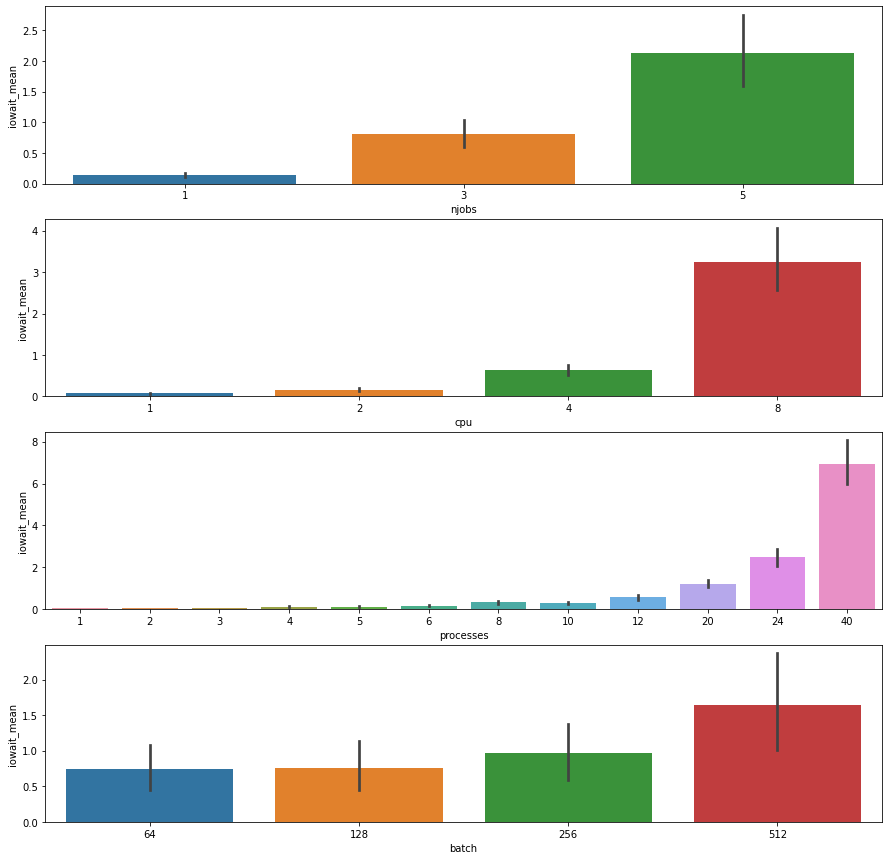

In [112]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.barplot(x='njobs', y='iowait_mean', data=final_df, ax=ax1)
sns.barplot(x='cpu', y='iowait_mean', data=final_df, ax=ax2)

final_df['processes'] = final_df['cpu'] * final_df['njobs']
sns.barplot(x='processes', y='iowait_mean', data=final_df, ax=ax3)
sns.barplot(x='batch', y='iowait_mean', data=final_df, ax=ax4);


final_df.groupby('njobs').mean()

## Run some statistical tests to see if the batch influences any of the outputs

In [113]:
# run for batch with the IO, CPU...

from scipy.stats import mannwhitneyu
import itertools

def njobs_significance_test(column: str):

    print('Starting jobs significance test for column', column)

    # Divide in batches
    n0 = final_df[final_df.njobs == 1][column]
    n1 = final_df[final_df.njobs == 3][column]
    n2 = final_df[final_df.njobs == 5][column]

    jobs = {1: n0,
               3:n1,
               5:n2
    }

    # Calculate p-values
    combinations = itertools.combinations(list(jobs.keys()), 2)
    for i, j in combinations:
        # Calculate the test for those two values
        _, p_val = mannwhitneyu(jobs[i], jobs[j])
        print(f'P-value of {i} and {j} is {p_val} --> {"RELEVANT" if p_val < 0.05 else "NON_RELEVANT"}')
    print()

def cpu_significance_test(column: str):

    print('Starting cpu significance test for column', column)

    # Divide in batches
    c0 = final_df[final_df.cpu == 1][column]
    c1 = final_df[final_df.cpu == 2][column]
    c2 = final_df[final_df.cpu == 4][column]
    c3 = final_df[final_df.cpu == 8][column]

    cpus = {1: c0,
               2:c1,
               4:c2,
               8:c3
    }

    # Calculate p-values
    combinations = itertools.combinations(list(cpus.keys()), 2)
    for i, j in combinations:
        # Calculate the test for those two values
        _, p_val = mannwhitneyu(cpus[i], cpus[j])
        print(f'P-value of {i} and {j} is {p_val} --> {"RELEVANT" if p_val < 0.05 else "NON_RELEVANT"}')
    print()


def batch_significance_test(column: str):

    print('Starting batch significance test for column', column)

    # Divide in batches
    b0 = final_df[final_df.batch == 64][column]
    b1 = final_df[final_df.batch == 128][column]
    b2 = final_df[final_df.batch == 256][column]
    b3 = final_df[final_df.batch == 512][column]

    batches = {64: b0,
               128:b1,
               256:b2,
               512:b3
    }

    # Calculate p-values
    combinations = itertools.combinations([64,128,256,512], 2)
    for i, j in combinations:
        # Calculate the test for those two values
        _, p_val = mannwhitneyu(batches[i], batches[j])
        print(f'P-value of {i} and {j} is {p_val} --> {"RELEVANT" if p_val < 0.05 else "NON_RELEVANT"}')
    print()

for col in ['time', 'final_accuracy', 'cpu_mean', 'iowait_mean']:
    print(f'--------- {col.upper()} ------------')
    batch_significance_test(col)
    njobs_significance_test(col)
    cpu_significance_test(col)

--------- TIME ------------
Starting batch significance test for column time
P-value of 64 and 128 is 1.1619800428063695e-21 --> RELEVANT
P-value of 64 and 256 is 1.9969209113433261e-25 --> RELEVANT
P-value of 64 and 512 is 1.9943174839682347e-25 --> RELEVANT
P-value of 128 and 256 is 1.3798612084569241e-21 --> RELEVANT
P-value of 128 and 512 is 3.287687469152842e-25 --> RELEVANT
P-value of 256 and 512 is 1.8783246132285714e-13 --> RELEVANT

Starting jobs significance test for column time
P-value of 1 and 3 is 0.06350631746647104 --> NON_RELEVANT
P-value of 1 and 5 is 0.00017314928812964793 --> RELEVANT
P-value of 3 and 5 is 0.020276010691700024 --> RELEVANT

Starting cpu significance test for column time
P-value of 1 and 2 is 0.33595533142819545 --> NON_RELEVANT
P-value of 1 and 4 is 0.2718186163727916 --> NON_RELEVANT
P-value of 1 and 8 is 0.183795950433066 --> NON_RELEVANT
P-value of 2 and 4 is 0.43493729710873774 --> NON_RELEVANT
P-value of 2 and 8 is 0.09808237659073671 --> NON_RE

## Try to calculate the service rate of the disk based on the number of jobs and the batch

In [155]:
Tcpu = 0.045
mu_cpu = 1/Tcpu
num_examples = 60000
num_epochs = 10

# Surprisingly, the batch size doesn't influence cpu utilization??
serv_df = final_df.groupby(['batch', 'njobs']).mean()
display(serv_df)

mus = {
    'batch':[],
    'cpu':[],
    'processes':[],
    'njobs':[],
    'mu':[]
}

for i, row in final_df.iterrows():
    # Calculate the new numbers
    l_disk = row.njobs * mu_cpu
    T = row.time
    Nt = (num_examples/row.batch) * num_epochs
    mu_disk = (1/((T/Nt) - Tcpu)) + l_disk
    
    mus['batch'].append(row.batch)
    mus['cpu'].append(row.cpu)
    mus['processes'].append(row.njobs * row.cpu)
    mus['njobs'].append(row.njobs)
    mus['mu'].append(mu_disk)

    
df_mu = pd.DataFrame(mus)

display(df_mu)
df_mu.groupby(['batch', 'njobs']).mean()

replication   cpu        time  final_accuracy   cpu_mean  \
batch njobs                                                             
64    1              2.0  3.75  486.848535        0.954950  10.170259   
      3              2.0  3.75  564.825485        0.954621  14.867009   
      5              2.0  3.75  686.268603        0.955192  20.220120   
128   1              2.0  3.75  264.916728        0.941729  10.373407   
      3              2.0  3.75  327.940669        0.943133  15.527409   
      5              2.0  3.75  376.806774        0.940954  20.991655   
256   1              2.0  3.75  155.325168        0.925017  11.132857   
      3              2.0  3.75  177.707407        0.925992  17.073606   
      5              2.0  3.75  219.742506        0.925283  22.421810   
512   1              2.0  3.75   97.419119        0.901783  12.416363   
      3              2.0  3.75  110.412065        0.901892  19.584804   
      5              2.0  3.75  148.954259        0.903225  23.066531   

             iowait_mean  processes  
batch njobs                          
64    1         0.096079       3.75  
      3         0.534435      11.25  
      5         1.602815      18.75  
128   1         0.081865       3.75  
      3         0.547617      11.25  
      5         1.650599      18.75  
256   1         0.140890       3.75  
      3         0.805024      11.25  
      5         1.962710      18.75  
512   1         0.228127       3.75  
      3         1.365503      11.25  
      5         3.336458      18.75

,batch,cpu,processes,njobs,mu
0,64,1,1,1,153.092793
1,64,2,2,1,190.995569
2,256,4,4,1,70.999034
3,256,8,8,1,70.609607
4,512,1,1,1,31.449850
...,...,...,...,...,...
283,256,8,40,5,124.053230
284,512,1,5,5,129.731243
285,512,2,10,5,126.297013
286,512,4,20,5,126.297013


cpu  processes          mu
batch njobs                             
64    1      3.75       3.75  246.203559
      3      3.75      11.25  201.359497
      5      3.75      18.75  170.249869
128   1      3.75       3.75  118.319729
      3      3.75      11.25  124.509015
      5      3.75      18.75  147.936041
256   1      3.75       3.75   97.281131
      3      3.75      11.25  112.993170
      5      3.75      18.75  135.385283
512   1      3.75       3.75   56.670022
      3      3.75      11.25   94.933410
      5      3.75      18.75  125.211696

We see that the service rate stabilizes at around 125-130 rps


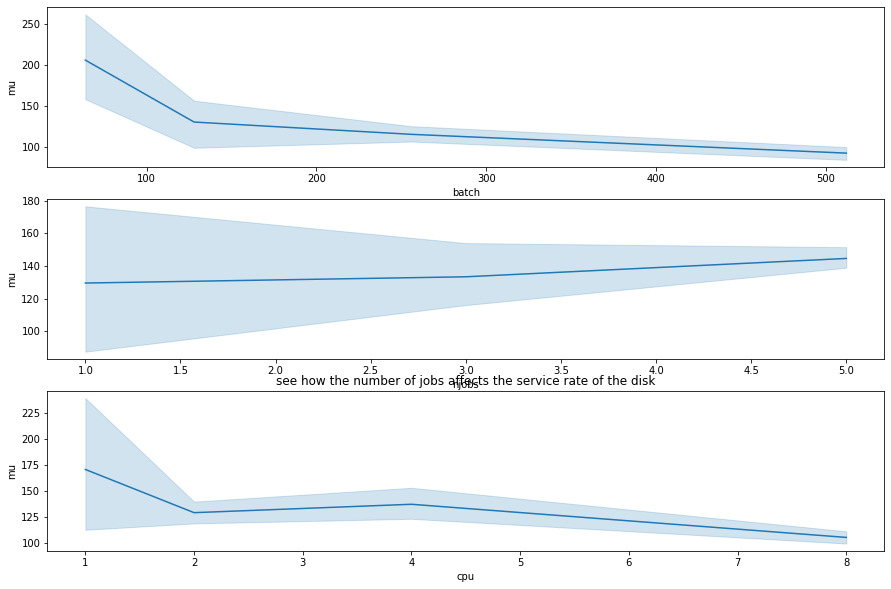

In [157]:
f, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 10))

plt.title('see how the number of jobs affects the service rate of the disk')
sns.lineplot(x='batch', y='mu', data=df_mu, ax=ax1)
sns.lineplot(x='njobs', y='mu', data=df_mu, ax=ax2)
sns.lineplot(x='cpu', y='mu', data=df_mu, ax=ax3)

print('We see that the service rate stabilizes at around 125-130 rps')

In [159]:
# Try to fit a linear regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# print((X[:,0]**2).shape)
X = df_mu[['batch', 'cpu', 'processes', 'njobs']].values
# print((X[:,0]**2).shape)
# X = np.hstack((X, (X[:,0]**2).reshape(-1,1), (X[:,1]**2).reshape(-1,1)))


l = LinearRegression()
l.fit(X, df_mu['mu'])

display(l.intercept_, l.coef_)

# so the best line of how it varies --> mu = -0.15 * batch + 4.23 * njobs + 145

# get the parameters

coef_batch, coef_cpu, coef_proc, coef_jobs = l.coef_
intercept = l.intercept_


# mean_squared_error(y_pred, df_mu['mu'])


205.8353559429729

array([-0.20288854, -8.67437477,  0.4130439 ,  2.22036332])

In [160]:
def get_mu_disk(batch, jobs):
    return coef_batch * batch + coef_jobs * jobs  + intercept

# Take the mean of the mu as 120
print('Get the predictions of the response time based on the batch and number of jobs')
# Total time = Ncycles * (E(Tcpu) + E(t_disk)) 
Tcpu = 0.045
mu_cpu = 1/Tcpu

res = {
    'expected':[],
    'actual':[]
}

for (batch, njobs), row in serv_df.iterrows():
    # Measured time
    T_true = row.time
    
    # Apply the formula
    l_disk = njobs * mu_cpu
    mu_disk = get_mu_disk(batch, njobs)
    Nt = (num_examples/batch) * num_epochs
    Tdisk = 1/(mu_disk - l_disk)
    
    T = Nt * (Tcpu + Tdisk)
#     print(f'[Batch {batch}, Njobs {njobs}]--> Expected: {T}, Actual {T_true}')
    res['expected'].append(T)
    res['actual'].append(T_true)

    
res = pd.DataFrame(res)    
    
res
    

Get the predictions of the response time based on the batch and number of jobs


,expected,actual
0,476.113208,486.848535
1,492.446012,564.825485
2,522.853881,686.268603
3,240.259342,264.916728
4,250.045611,327.940669
5,269.636667,376.806774
6,122.973264,155.325168
7,130.431389,177.707407
8,148.962869,219.742506
9,67.033456,97.419119


## Run the ANOVA tests on this data 

We want to see how factors like number of CPUs, Jobs, and Batch influence all the others
- Accuracy
- E(T)
- CPU Usage
- IO Wait

In [123]:
def ANOVA(df: pd.DataFrame, y: str, use_all = False,verbose=False):
    """Run the ANOVA analysis with the cpu, batch and njobs columns for the 
    given output variable"""
    
    # If use all is true we use all the variables to check either accuracy and time
    # including also the iowait and the cpu to see what fully influences the stuff
    
    
    if not use_all:
        # Plot the summary dataframe
        if verbose:
            display(rp.summary_cont(results_df.groupby(['cpu', 'batch', 'njobs']))[y])

        model = ols(f'{y} ~ cpu*batch*njobs', df).fit()
        
    else:
        if y not in ['final_accuracy', 'time']:
            raise ValueError('When use_all = True we predict either final_accuracy or time, not', y)
        if verbose:
            display(rp.summary_cont(df.groupby(['cpu', 'batch', 'njobs', 'cpu_mean', 'iowait_mean']))[y])

        model = ols(f'{y} ~ cpu*batch*njobs*cpu_mean*iowait_mean', df).fit()
        

    if verbose:
        print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
        display(model.summary())
    
    res = sm.stats.anova_lm(model, typ=2)
    
    return res, model

In [124]:
# Simply change the output value for the y to the variable that you want to study
# - iowait_mean
# - final_accuracy
# - time
# - cpu_mean
res, model = ANOVA(final_df, y='time', verbose=True)
res

N      Mean        SD       SE  95% Conf.   Interval
cpu batch njobs                                                      
1   64    1      6  461.9658   50.3611  20.5598   409.1151   514.8165
          3      6  496.5998   66.5162  27.1551   426.7953   566.4042
          5      6  513.9026   40.7756  16.6466   471.1112   556.6939
    128   1      6  270.8872   59.1887  24.1637   208.7724   333.0019
          3      6  364.6631  170.8568  69.7520   185.3599   543.9663
          5      6  311.7335   53.1670  21.7053   255.9381   367.5289
    256   1      6  176.1057   60.3866  24.6527   112.7339   239.4775
          3      6  183.6100   58.2441  23.7780   122.4866   244.7334
          5      6  208.9538   59.2136  24.1739   146.8129   271.0947
    512   1      6  126.0491   57.6941  23.5535    65.5028   186.5954
          3      6  131.5958   59.7227  24.3817    68.9207   194.2709
          5      6  179.4456   58.8190  24.0128   117.7188   241.1723
2   64    1      6  500.9993   31.1294  12.7085   468.3310   533.6677
          3      6  517.3422   50.5555  20.6392   464.2875   570.3968
          5      6  579.5751   28.2537  11.5345   549.9247   609.2256
    128   1      6  270.3889   31.9665  13.0503   236.8421   303.9357
          3      6  286.8219   30.2435  12.3469   255.0832   318.5605
          5      6  322.3939   17.9004   7.3078   303.6086   341.1792
    256   1      6  157.3697   28.8352  11.7719   127.1090   187.6304
          3      6  167.5636   29.9572  12.2300   136.1254   199.0018
          5      6  200.2847   26.0156  10.6208   172.9830   227.5863
    512   1      6  101.3789   29.8375  12.1811    70.0663   132.6914
          3      6  103.5898   27.9099  11.3942    74.3002   132.8795
          5      6  135.2920   31.4516  12.8401   102.2856   168.2984
4   64    1      6  471.0374   34.1397  13.9375   435.2100   506.8648
          3      6  537.6531   31.1982  12.7366   504.9125   570.3936
          5      6  693.5207   20.8740   8.5218   671.6148   715.4267
    128   1      6  249.4808   20.8385   8.5073   227.6121   271.3494
          3      6  288.2822   19.1396   7.8137   268.1964   308.3680
          5      6  371.1987   18.4727   7.5415   351.8128   390.5846
    256   1      6  140.6738   16.9997   6.9401   122.8337   158.5138
          3      6  160.8890   22.5595   9.2099   137.2142   184.5637
          5      6  207.2361   14.6035   5.9619   191.9107   222.5616
    512   1      6   76.1689   26.6036  10.8609    48.2501   104.0877
          3      6   94.1737   16.5410   6.7528    76.8150   111.5324
          5      6  134.3155   22.9477   9.3684   110.2334   158.3976
8   64    1      6  513.3916   36.7192  14.9906   474.8571   551.9260
          3      6  707.7069   38.3211  15.6445   667.4914   747.9225
          5      6  958.0760   50.7000  20.6982   904.8695  1011.2824
    128   1      6  268.9100   16.9932   6.9374   251.0768   286.7433
          3      6  371.9955   27.4064  11.1886   343.2343   400.7567
          5      6  501.9010   24.4684   9.9892   476.2230   527.5790
    256   1      6  147.1515   12.6371   5.1591   133.8898   160.4133
          3      6  198.7670   10.8089   4.4127   187.4237   210.1103
          5      6  262.4954   36.9875  15.1001   223.6794   301.3115
    512   1      6   86.0796   10.7844   4.4027    74.7621    97.3972
          3      6  112.2889   10.1458   4.1420   101.6416   122.9363
          5      6  146.7640   12.8416   5.2425   133.2876   160.2404

Overall model F( 7, 280) =  97.037, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     97.04
Date:                Fri, 23 Oct 2020   Prob (F-statistic):           4.14e-71
Time:                        17:39:23   Log-Likelihood:                -1753.9
No. Observations:                 288   AIC:                             3524.
Df Residuals:                     280   BIC:                             3553.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         423.5587     39.471     10.731      0.000     345.860     501.257
cpu               -11.3070      8.563     -1.321      0.188     -28.162       5.548
batch              -0.7183      0.134     -5.369      0.000      -0.982      -0.455
cpu:batch           0.0139      0.029      0.481      0.631      -0.043       0.071
njobs              -4.2566     11.556     -0.368      0.713     -27.004      18.491
cpu:njobs          12.6829      2.507      5.059      0.000       7.748      17.618
batch:njobs         0.0308      0.039      0.787      0.432      -0.046       0.108
cpu:batch:njobs    -0.0267      0.008     -3.138      0.002      -0.043      -0.010
==============================================================================
Omnibus:                       15.156   Durbin-Watson:                   0.823
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               10.642
Skew:                           0.351   Prob(JB):                      0.00489
Kurtosis:                       2.372   Cond. No.                     3.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,sum_sq,df,F,PR(>F)
cpu,2.454453e+05,1.0,20.918743,7.203540e-06
batch,6.469289e+06,1.0,551.362732,3.961122e-68
cpu:batch,2.658836e+05,1.0,22.660655,3.103131e-06
njobs,5.476600e+05,1.0,46.675806,5.217218e-11
cpu:njobs,2.179075e+05,1.0,18.571754,2.267986e-05
batch:njobs,1.081739e+05,1.0,9.219413,2.620142e-03
cpu:batch:njobs,1.155602e+05,1.0,9.848928,1.880727e-03
Residual,3.285316e+06,280.0,NaN,NaN


In [125]:
model.params

Intercept          423.558693
cpu                -11.307043
batch               -0.718293
cpu:batch            0.013947
njobs               -4.256568
cpu:njobs           12.682946
batch:njobs          0.030830
cpu:batch:njobs     -0.026666
dtype: float64

## Fit the Data with the Random Forest Classifier

In [142]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor

scaler = StandardScaler()


# Get the data split into train and test
train_df = final_df[['processes', 'cpu', 'njobs', 'batch', 'network']]
train_df['network'] = train_df['network'].apply(lambda net: 1 if net == 'lenet5' else -1)

labels_time = final_df['time']
labels_acc = final_df['final_accuracy']

train_df = scaler.fit_transform(train_df)
train_df

c:\users\diego\cs\qpe\venv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


array([[-0.93045745, -1.02575529, -1.22474487, -1.02575529,  1.        ],
       [-0.83968112, -0.65275337, -1.22474487, -1.02575529,  1.        ],
       [-0.65812844,  0.09325048, -1.22474487,  0.09325048,  1.        ],
       ...,
       [-0.11347042, -0.65275337,  1.22474487,  1.58525817, -1.        ],
       [ 0.79429295,  0.09325048,  1.22474487,  1.58525817, -1.        ],
       [ 2.60981969,  1.58525817,  1.22474487,  1.58525817, -1.        ]])

In [143]:
# Fit just the Random Forest regressor with a GridSearch crossval to find the best hyperparams

x_train, x_test, y_train_acc, y_test_acc = train_test_split(train_df, labels_acc, test_size=0.2, random_state = 42)
x_train, x_test, y_train_time, y_test_time = train_test_split(train_df, labels_time, test_size=0.2, random_state = 42)

reg_acc = RandomForestRegressor(random_state=42)
reg_time = RandomForestRegressor(random_state=42)

params_rf = {
    'n_estimators': [50, 100, 150, 200, 500,1000, 2000],
    'max_features': ['auto', 'log2', 'sqrt'],
    'max_depth': range(4,10),
    'criterion': ['mse', 'mae']
    
}

# First cross validation
print('Fitting the time...')
cv_time = GridSearchCV(estimator=reg_time, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_time.fit(x_train, y_train_time)


# Second cross val
print('Fitting the accuracy')
cv_acc = GridSearchCV(estimator=reg_acc, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_acc.fit(x_train, y_train_acc)

Fitting the time...
Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 144 tasks      | elapsed:   14.7s
[Parallel(n_jobs=8)]: Done 304 tasks      | elapsed:   32.5s
[Parallel(n_jobs=8)]: Done 528 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 816 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 1168 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 1260 out of 1260 | elapsed:  3.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting the accuracy
Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 144 tasks      | elapsed:   16.3s
[Parallel(n_jobs=8)]: Done 304 tasks      | elapsed:   41.6s
[Parallel(n_jobs=8)]: Done 528 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 816 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 1168 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 1260 out of 1260 | elapsed:  3.3min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=8,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': range(4, 10),
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'n_estimators': [50, 100, 150, 200, 500, 1000, 2000]},
             verbose=3)

### Fit the regressors on the accuracy and time

In [135]:
cv_acc.best_params_

{'criterion': 'mae',
 'max_depth': 9,
 'max_features': 'auto',
 'n_estimators': 150}

In [136]:
cv_time.best_params_

{'criterion': 'mae',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 2000}

In [144]:
from sklearn.metrics import mean_squared_error

# 1) Fit on the time
r_t = cv_time.best_estimator_.fit(x_train, y_train_time)

# test the performance on the train and the test set
y_pred = r_t.predict(x_test)

err = mean_squared_error(y_pred, y_test_time)

print('Mean Squared Error with the test set is for TIME', err)


# 2) Fit on the acc
r_acc = cv_acc.best_estimator_.fit(x_train, y_train_acc)

# test the performance on the train and the test set
y_pred = r_acc.predict(x_test)
err = mean_squared_error(y_pred, y_test_acc)

print('Mean Squared Error with the test set is for ACCURACY', err)

Mean Squared Error with the test set is for TIME 463.8357930080326
Mean Squared Error with the test set is for ACCURACY 1.1920753068965659e-05


## Create the Final Optimizer that will multiplex the regressors seen above

In [138]:
# Import the 3 regressors
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, LeaveOneOut, cross_validate


from typing import Tuple, Optional
# Declare the class for the ML model

from dataclasses import dataclass

@dataclass
class Job:
    cpu:int
    njobs: int
    network: int


class Courier:
    """ Courier has 3 parameters to account for utilization, accuracy and response time,
    based on which, and their weights, it chooses the optimal batch size for the task

    labels are in format dict
    accuracy -> labels
    time -> labels
    utilization -> labels
    """

    def __init__(self, alpha: float, beta: float,
                models: dict, scaler, batches=[64,128,256,512]):


        self.batches = np.array(batches).reshape(len(batches), 1)
        

        if alpha + beta !=1:
            raise ValueError('The hyperparameters need to add up to 1')

        # Configure the hyperparams and the training data
        self.alpha = alpha
        self.beta = beta
        
        
        self.scaler = scaler

        # Compute the predictors
        self.acc_model = models['accuracy']
        self.time_model = models['time']

    def optimize(self, job: Job, latency = None):
        acc, t = self._predict(job)
        
        b = self.batches


        if latency:
            # Just take the options that satisfy the requirements
            fit = t[t<latency]
            if len(fit) == 0:
                print('Not a single value fulfills the '
                      'time requirements, selecting minimum time')
                # Return the minimum time
                min_t_idx = np.where(t == t.min())[0][0]
                return self.batches[min_t_idx], (acc[min_t_idx],
                                                 t[min_t_idx])

            else:
                acc = acc[t<latency]
                b = self.batches[t<latency]
                t = t[t<latency]


        # Return the batch that better fulfills the requirements and
        # also return a tuple with the predictions
        sc_a = acc/np.max(acc)
        sc_t = 1-( t/np.max(t))

        sc = self.alpha * sc_a + self.beta * sc_t

        # Get the index of the max score
        max_sc_idx = np.where(sc == sc.max())[0][0]
        return  b[max_sc_idx], (acc[max_sc_idx],
                                           t[max_sc_idx])



    def _fit_model(self, labels):
        """Fit the model to particular labels"""
        reg = self.model
        reg.fit(self.X, labels)
        return reg


    def _preprocess_data(self, X):
        """Standardizes the data"""
        scaler = StandardScaler()
        return scaler.fit_transform(X)

    def _predict(self, job: Job):
        """Predicts the time, accuracy and util with different batches
        and returns the best one given the optims"""

        acc = []
        t = []
        
        # predict the performance of the job with different batches
        for b in self.batches:
            data_point = self.scaler.transform([[job.cpu * job.njobs, b, job.network]])
            _acc = self.acc_model.predict(data_point)
            _t = self.time_model.predict(data_point)
            print(f'Batch {b}, acc = {_acc} and t = {_t}')

            acc.append(_acc)
            t.append(_t)


        return np.array(acc), np.array(t)




In [139]:
# Create the Courier

c = Courier(alpha = 0.98, beta=0.02, 
            models= {
                'accuracy': r_acc,
                'time': r_t
},
           scaler=scaler)

In [140]:
# Get some predidctions from the Courier

j = Job(cpu = 10, njobs=8, network=-1)
batch, prediction = c.optimize(j, latency=400)

print(f'Recommended batch {batch}, predictions {prediction}')

Batch [64], acc = [0.94930967] and t = [948.06088009]
Batch [128], acc = [0.93843367] and t = [487.35442721]
Batch [256], acc = [0.92699967] and t = [237.30970084]
Batch [512], acc = [0.914307] and t = [132.55367127]
Recommended batch 256, predictions (0.9269996666666674, 237.30970084489798)
